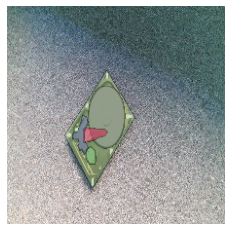

In [1]:
import json, random
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw, ImagePath
import os, cv2
import matplotlib.pyplot as plt


def plotSegmentation(seg, saveName):
    RGBImg = np.moveaxis(seg[0:3], -0, -1) #Reshape channeL from [C, H, W] to [H, W, C]
    plt.imshow(RGBImg)
    for i in range(5):
        color = cv2.cvtColor(seg[3+i], cv2.COLOR_GRAY2BGRA)
        color[:,:,0] = color[:,:,0]/255*random.randint(1,255)
        color[:,:,1] = color[:,:,1]/255*random.randint(1,255)
        color[:,:,2] = color[:,:,2]/255*random.randint(1,255)
        color[color[:,:,0]==0,3] = color[color[:,:,0]==0,3]-255
        plt.imshow(color, alpha=0.5)
    plt.axis('off')
    if not os.path.exists('checkSeg'):
        os.makedirs('checkSeg')
    plt.savefig('./checkSeg/'+saveName)

resArr = []
resName = []
with open('../Dataset/UB-Data/annotations_all.json') as json_file:
    data = json.load(json_file)
    width = 960
    height = 540
    for i in range(len(data["images"])):
        imgPath = data["images"][i]["file_name"]
        imgName = imgPath.split('/')[1]
        imgName = imgName.split('.')[0]
        OriImg = cv2.imread(imgPath) #BGR
        OriImg = cv2.resize(OriImg,(224,224)) #Resize images
        OriResSizeImg = np.moveaxis(OriImg, -1, 0) #Reshape channeL from [H, W, C] to [C, H, W]
        resName.append(imgName)
        tmpRes = [[],[],[],[],[]]
        bk = np.zeros((224, 224)) #Background
        for j in range(5):
            segXY = data['annotations'][i*5+j]['segmentation'][0]
            categoryID = data['annotations'][i*5+j]['category_id']
            image = ImagePath.Path(segXY).getbbox()
            img = Image.new('L', (width, height), 0)
            img1 = ImageDraw.Draw(img)
            img1.polygon(segXY, fill ="#ffffff", outline ="#ffffff")
            img = img.resize((224, 224)) #Resize images
            mask = np.array(img) #mask component part
            tmpRes[categoryID-1] = mask #Save mask
            bk += mask
        bk[bk>0]=-1
        bk[bk==0]=255
        bk[bk==-1]=0
        bk = bk.astype('uint8')
        tmpRes.append(bk) #Save mask            
        tmpRes = np.array(tmpRes)
        megRes = np.vstack((OriResSizeImg, tmpRes))
        plotSegmentation(megRes, 'Check-'+imgName) #To check seg
        resArr.append(megRes.tolist())
    resName = np.array(resName)
    resArr = np.array(resArr, dtype='uint8')
'''
The shape of DatasetArr.npy is [B,C,H,W].
[B,0:3,H,W] = BGR original image for input
[B,3,H,W] = Segmentation for hard_disk
[B,4,H,W] = Segmentation for disk
[B,5,H,W] = Segmentation for chip
[B,6,H,W] = Segmentation for reader
[B,7,H,W] = Segmentation for y_part
[B,8,H,W] = Segmentation for background
'''

np.save('../Dataset/DatasetArrV2.npy', resArr)   
np.save('../Dataset/ImgsNameV2.npy', resName)     


